# Image generation (plus some gold mining)

In [2]:
import sys, os
sys.path.append('../')

import logging
import numpy as np
import matplotlib.pyplot as plt

from units import *
from simulation import SubhaloSimulator

logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

## Training parameters

In [5]:
mass_base_unit = 1.e7 * M_s

alpha_mean = 2000. # 100  # 100 is just 2e8/M_s * mass_base_unit * (mass_base_unit / M_s)**-1.9
alpha_std = alpha_mean * 0.2

print(alpha_mean, "+/-", alpha_std)

beta_mean = -1.9
beta_std = 0.2

alpha_ref = 200.
beta_ref = -1.9

2000.0 +/- 400.0


In [4]:
n_train = 5000

alpha = np.random.normal(loc=alpha_mean, scale=alpha_std, size=n_train)
beta = np.random.normal(loc=beta_mean, scale=beta_std, size=n_train)
parameters = np.vstack((alpha, beta)).T

assert np.min(alpha) > 0.
assert np.max(beta) < -1.

## Generate train data

In [6]:
sim = SubhaloSimulator(
    mass_base_unit=mass_base_unit,
    resolution=64,
    m_sub_min=100.,
)

In [7]:
y0 = np.zeros(n_sims)
x0, t_xz0, log_r_xz0, latents0 = sim.rvs_score_ratio(
    alpha,
    beta,
    alpha_ref,
    beta_ref,
    n_sims
)

15:54 simulation           INFO    Simulating image 250 / 5000
15:57 simulation           INFO    Simulating image 500 / 5000
16:01 simulation           INFO    Simulating image 750 / 5000
16:05 simulation           INFO    Simulating image 1000 / 5000
16:08 simulation           INFO    Simulating image 1250 / 5000
16:12 simulation           INFO    Simulating image 1500 / 5000
16:16 simulation           INFO    Simulating image 1750 / 5000
16:20 simulation           INFO    Simulating image 2000 / 5000
16:24 simulation           INFO    Simulating image 2250 / 5000
16:29 simulation           INFO    Simulating image 2500 / 5000
16:35 simulation           INFO    Simulating image 2750 / 5000
16:38 simulation           INFO    Simulating image 3000 / 5000
16:42 simulation           INFO    Simulating image 3250 / 5000
16:47 simulation           INFO    Simulating image 3500 / 5000
16:51 simulation           INFO    Simulating image 3750 / 5000
16:54 simulation           INFO    Simulati

In [8]:
y1 = np.ones(n_sims)
x1, t_xz1, log_r_xz1, latents1 = sim.rvs_score_ratio(
    alpha_ref,
    beta_ref,
    alpha,
    beta,
    n_sims
)

17:09 simulation           INFO    Simulating image 250 / 5000
17:09 simulation           INFO    Simulating image 500 / 5000
17:09 simulation           INFO    Simulating image 750 / 5000
17:10 simulation           INFO    Simulating image 1000 / 5000
17:10 simulation           INFO    Simulating image 1250 / 5000
17:10 simulation           INFO    Simulating image 1500 / 5000
17:10 simulation           INFO    Simulating image 1750 / 5000
17:10 simulation           INFO    Simulating image 2000 / 5000
17:11 simulation           INFO    Simulating image 2250 / 5000
17:11 simulation           INFO    Simulating image 2500 / 5000
17:11 simulation           INFO    Simulating image 2750 / 5000
17:11 simulation           INFO    Simulating image 3000 / 5000
17:11 simulation           INFO    Simulating image 3250 / 5000
17:12 simulation           INFO    Simulating image 3500 / 5000
17:12 simulation           INFO    Simulating image 3750 / 5000
17:12 simulation           INFO    Simulati

In [9]:
x = np.vstack((x0, x1))
y = np.hstack((y0, y1))
parameters = np.vstack((parameters, parameters))
log_r_xz = np.hstack((log_r_xz0, log_r_xz1))
t_xz = np.vstack((t_xz0, t_xz1))
latents = latents0 + latents1

r_xz = np.exp(log_r_xz, dtype=np.float64)
n_subs = np.array([v[0] for v in latents])
m_subs = [v[1] for v in latents]
pos_subs = [np.vstack((v[2], v[3])).T for v in latents]

In [10]:
if not os.path.exists("../data"):
    os.mkdir("../data")

np.save("../data/theta.npy", parameters)
np.save("../data/x.npy", x)
np.save("../data/y.npy", y)
np.save("../data/t_xz.npy", t_xz)
np.save("../data/r_xz.npy", r_xz)
np.save("../data/log_r_xz.npy", log_r_xz)

## Generate test data

In [6]:
alpha_true = 10000.
beta_true = -1.9

n_test = 500

In [7]:
sim = SubhaloSimulator(
    mass_base_unit=mass_base_unit,
    resolution=64,
    m_sub_min=100.,
)

x0, _ = sim.rvs(alpha_true, beta_true, n_test)
y0 = np.zeros(n_test)

x1, _ = sim.rvs(alpha_ref, beta_ref, n_test)
y1 = np.ones(n_test)

x_test = np.vstack((x0, x1))
y_test = np.hstack((y0, y1))
theta_test = np.array([[alpha_true, beta_true] for i in range(2*n_test)])

09:32 simulation           INFO    Simulating image 25 / 500
09:33 simulation           INFO    Simulating image 50 / 500
09:34 simulation           INFO    Simulating image 75 / 500
09:36 simulation           INFO    Simulating image 100 / 500
09:37 simulation           INFO    Simulating image 125 / 500
09:39 simulation           INFO    Simulating image 150 / 500
09:41 simulation           INFO    Simulating image 175 / 500
09:43 simulation           INFO    Simulating image 200 / 500
09:45 simulation           INFO    Simulating image 225 / 500
09:48 simulation           INFO    Simulating image 250 / 500
09:50 simulation           INFO    Simulating image 275 / 500
09:53 simulation           INFO    Simulating image 300 / 500
09:56 simulation           INFO    Simulating image 325 / 500
09:58 simulation           INFO    Simulating image 350 / 500
10:01 simulation           INFO    Simulating image 375 / 500
10:03 simulation           INFO    Simulating image 400 / 500
10:06 simul

NameError: name 'n_observations' is not defined

In [13]:

y0 = np.zeros(n_test)

x1, _ = sim.rvs(alpha_ref, beta_ref, n_test)
y1 = np.ones(n_test)

x_test = np.vstack((x0, x1))
y_test = np.hstack((y0, y1))
theta_test = np.array([[alpha_true, beta_true] for i in range(2*n_test)])

10:56 simulation           INFO    Simulating image 25 / 500
10:56 simulation           INFO    Simulating image 50 / 500
10:56 simulation           INFO    Simulating image 75 / 500
10:56 simulation           INFO    Simulating image 100 / 500
10:56 simulation           INFO    Simulating image 125 / 500
10:56 simulation           INFO    Simulating image 150 / 500
10:56 simulation           INFO    Simulating image 175 / 500
10:56 simulation           INFO    Simulating image 200 / 500
10:56 simulation           INFO    Simulating image 225 / 500
10:56 simulation           INFO    Simulating image 250 / 500
10:56 simulation           INFO    Simulating image 275 / 500
10:56 simulation           INFO    Simulating image 300 / 500
10:56 simulation           INFO    Simulating image 325 / 500
10:56 simulation           INFO    Simulating image 350 / 500
10:56 simulation           INFO    Simulating image 375 / 500
10:56 simulation           INFO    Simulating image 400 / 500
10:56 simul

In [14]:
if not os.path.exists("../data"):
    os.mkdir("../data")

np.save("../data/theta_test.npy", theta_test)
np.save("../data/x_test.npy", x_test)
np.save("../data/y_test.npy", y_test)

## A first look at the data

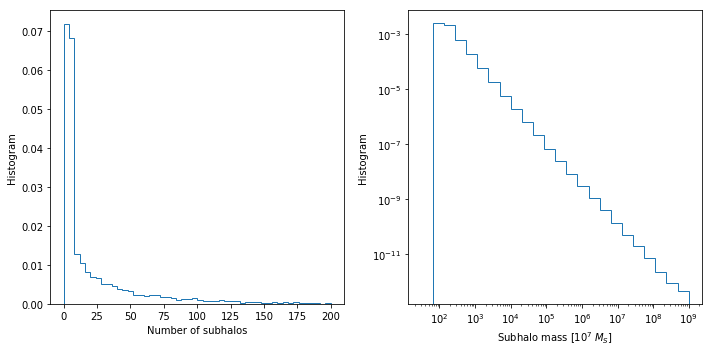

In [11]:
fig = plt.figure(figsize=(10,5))

# Number of subhalos
ax = plt.subplot(1,2,1)
plt.hist(n_subs, bins=50, range=(0,200), histtype='step', density=True)
plt.xlabel(r'Number of subhalos')
plt.ylabel(r'Histogram')

# Masses
ax = plt.subplot(1,2,2)
bins = 10**(np.linspace(1.5, 9, 25))
plt.hist(np.hstack(m_subs), bins=bins, histtype='step', density=True)
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')
plt.xlabel(r'Subhalo mass [$10^7 \; M_S$]')
plt.ylabel(r'Histogram')

plt.tight_layout()
plt.savefig("subhalo_params.pdf")

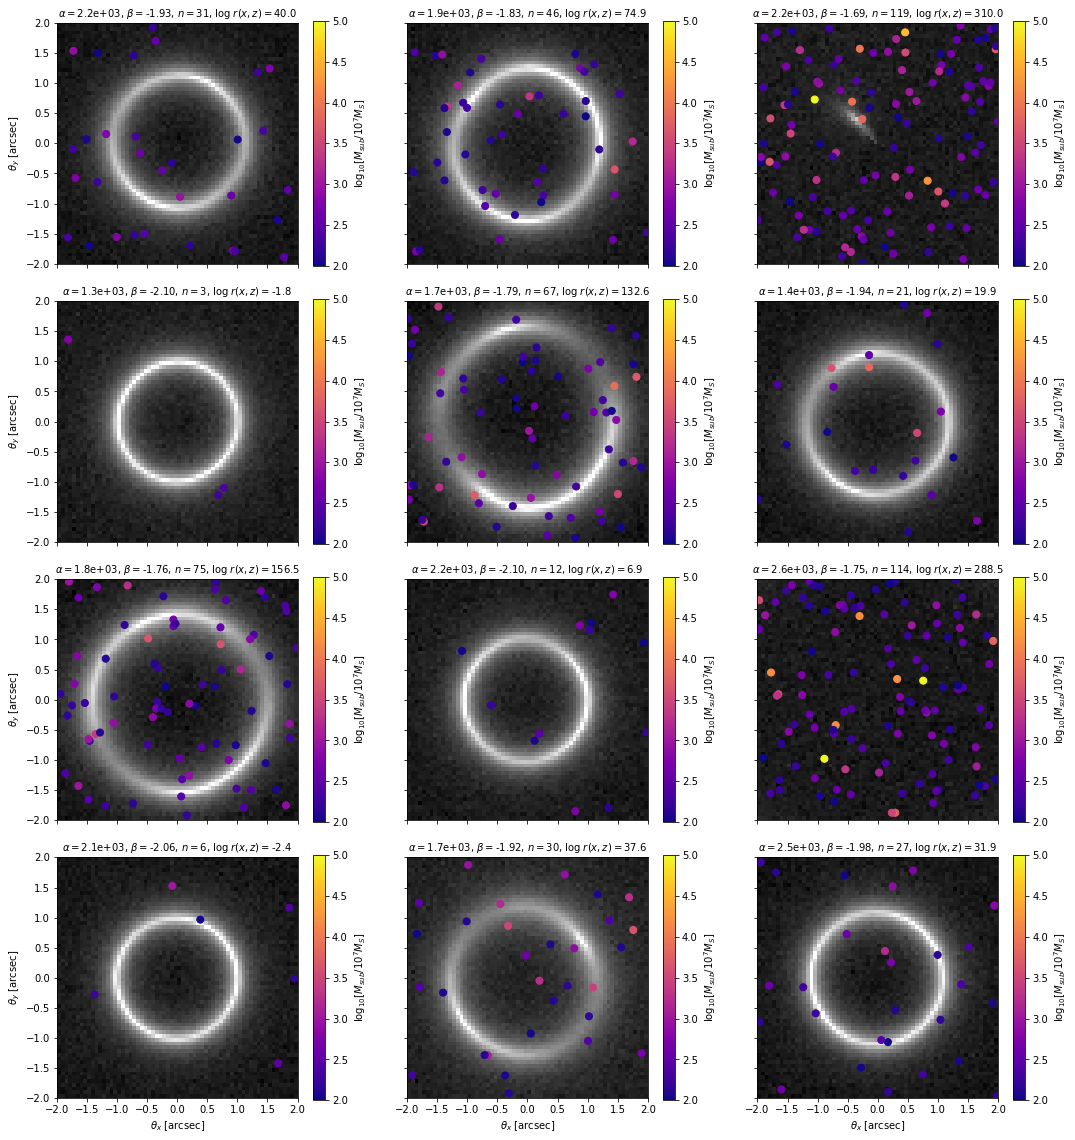

In [12]:
plt.figure(figsize=(15,16))

for i in [9,10,11,0,3,6,1,2,4,5,7,8]:
    if i == 9:
        ax_y = plt.subplot(4,3,i+1)
        ax_x = ax_y
    elif i in [10,11]:
        ax_x = plt.subplot(4,3,i+1, sharey=ax_y)
    elif i in [0,3,6]:
        ax_y = plt.subplot(4,3,i+1, sharex=ax_x)
    else:
        ax = plt.subplot(4,3,i+1, sharey=ax_y, sharex=ax_x)
        
    plt.imshow(
        np.log10(x[i]),
        vmax=3.5,
        cmap='gist_gray',
        extent=(-2.,2.,-2.,2.),
        origin="lower"
    )
    sc = plt.scatter(
        pos_subs[i][:,0],
        pos_subs[i][:,1],
        s=50.,
        c=np.log10(m_subs[i][:]),
        cmap="plasma",
        vmin=2.,
        vmax=5.,
    )
    cbar = plt.colorbar(sc)
    
    plt.xlim(-2.,2.)
    plt.ylim(-2.,2.)
    
    description = r"$\alpha = ${:.1e}, $\beta = ${:.2f}, $n = {}$, $\log \; r(x,z) = ${:.1f}".format(
            alpha[i],
            beta[i],
            n_subs[i],
            log_r_xz[i]
        )
    plt.title(
        description,
        fontsize=10
    )
    if i in [9,10,11]:
        plt.xlabel(r"$\theta_x$ [arcsec]")
    else:
        plt.setp(plt.gca().get_xticklabels(), visible=False)
    if i in [0,3,6,9]:
        plt.ylabel(r"$\theta_y$ [arcsec]")
    else:
        plt.setp(plt.gca().get_yticklabels(), visible=False)
    cbar.set_label(r'$\log_{10} [M_{sub} / 10^7 M_S]$')
    
    
plt.tight_layout()
plt.savefig("subhalos.pdf")